Linear algebra
==============

Silent substitution problems may be solved with linear algebra.

Basic example
-------------

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: BCGAR (8-bit, linear)
Ignoring: ['rh']
Minimising: ['mc', 'lc', 'mel']
Modulating: ['sc']
Target contrast: [ 0.2]
Background: [0.5, 0.5, 0.5, 0.5, 0.5]




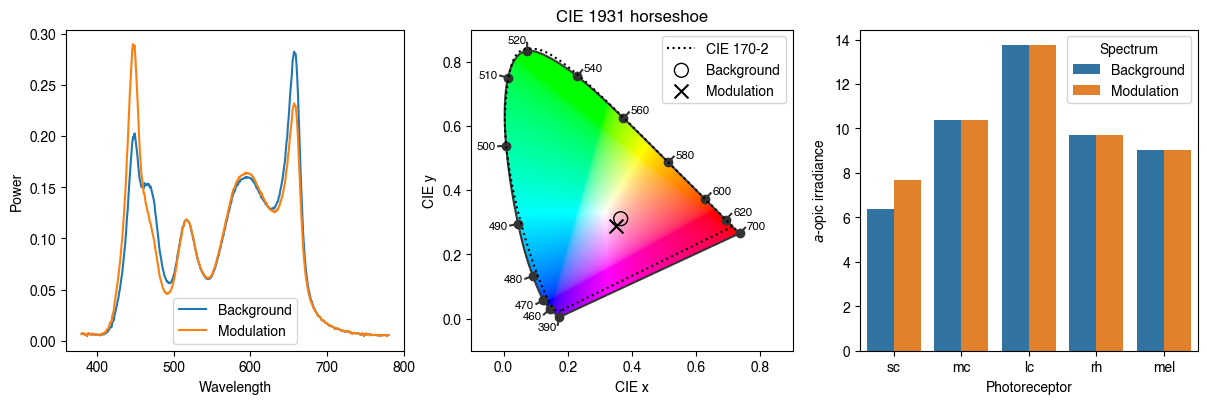

In [5]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

# Instantiate the problem class
ssp = SSP.from_json('../../data/BCGAR.json')

# Define problem
ssp.ignore = ['rh']
ssp.modulate = ['sc']
ssp.minimize = ['mc', 'lc', 'mel']
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .2
ssp.print_problem()

# Find solution
solution = ssp.linalg_solve()

# Plot solution
fig = ssp.plot_solution(solution)

In [25]:
print(f'The background settings are: {ssp.w2s(ssp.background)}')
print(f'The modulation settings are: {ssp.w2s(solution)}')

The background settings are: [127, 127, 127, 127, 127]
The modulation settings are: [205, 79, 128, 130, 98]


Worked example
--------------

For a background spectrum we will take the mixture of all primaries at half-max power, $\alpha_{bg} = [.5 \ .5 \ .5 \ .5 \ .5]$. Note that in this case we are not summing the predicted spectra as we'll be doing matrix algebra involving the individual primaries.

In [2]:
abg = [.5, .5, .5, .5, .5]
bg_spds = ssp.predict_multiprimary_spd(abg, nosum=True)
bg_spds

Primary,0,1,2,3,4
Wavelength,,,,,
380,0.001098,0.000856,0.001115,0.001842,0.001736
381,0.001134,0.000933,0.001191,0.002067,0.002040
382,0.000991,0.000838,0.001198,0.001945,0.001812
383,0.001091,0.000828,0.001231,0.001945,0.002044
384,0.000879,0.000745,0.001003,0.001673,0.001556
...,...,...,...,...,...
776,0.000625,0.000533,0.000710,0.002349,0.001355
777,0.000577,0.000525,0.000693,0.002305,0.001301
778,0.000516,0.000398,0.000562,0.002146,0.001093


Next, we'll be needing the spectral sensitivities for the photoreceptors.

In [1]:
from pysilsub.CIE import get_CIES026

sss = get_CIES026()
sss

,sc,mc,lc,rh,mel
Wavelength,,,,,
380,0.0,0.000000,0.000000,5.890000e-04,9.181600e-04
381,0.0,0.000000,0.000000,6.650000e-04,1.045600e-03
382,0.0,0.000000,0.000000,7.520000e-04,1.178600e-03
383,0.0,0.000000,0.000000,8.540000e-04,1.322800e-03
384,0.0,0.000000,0.000000,9.720000e-04,1.483800e-03
...,...,...,...,...,...
776,0.0,0.000002,0.000024,1.730000e-07,2.550000e-08
777,0.0,0.000002,0.000023,1.640000e-07,2.420000e-08
778,0.0,0.000002,0.000021,1.550000e-07,2.290000e-08


The dot product of these matrices, which we will call $A$, contains the *a*-opic irradiances for each primary component of the background spectrum.

In [4]:
A = sss.T.dot(bg_spds)
A

Primary,0,1,2,3,4
Photoreceptor,,,,,
S,3.580009,2.453689,0.211358,0.095264,0.057067
M,0.627573,1.355843,3.573256,4.683028,0.156777
L,0.435727,0.873636,2.915142,8.686473,0.853310
R,1.730730,2.965132,3.638927,1.288265,0.076642
I,2.094721,3.520715,2.841600,0.509312,0.069365


Now, the unique scaling coefficients for the primaries $\alpha_{sc} = [p_{0} \ p_{1} \ p_{2} \ p_{3} \ p_{4}]$ that must be added to the primary weights for the background $\alpha_{bg}$ for a requested modulation $\beta = [S \ M \ L \ R \ I]$, are discovered as $\alpha_{sc} = \beta A^{-1}$.

In [5]:
import numpy as np
import pandas as pd

# Calculate inverse of A
A1 = pd.DataFrame(
    np.linalg.inv(A.values),
    A.columns, 
    A.index)
A1

Photoreceptor,S,M,L,R,I
Primary,,,,,
0,0.473797,-0.159332,-0.001803,0.993080,-1.104764
1,-0.279487,0.340021,-0.037472,-1.654925,1.750941
2,-0.002424,-0.286409,0.015329,1.342032,-1.022070
3,0.026572,0.502356,-0.059770,-0.855885,0.523675
4,-0.218010,-4.402157,1.767262,5.315177,-3.067724


In [6]:
# Requested modulation for S-cones
requested_contrast = .2

b = np.array([requested_contrast, 0., 0., 0., 0.])

# Scale requested contrasts to percentage of background units
b = A.sum(axis=1).mul(b)

# Calculate the scaling coefficients
asc = A1.dot(b) / 2
asc

Primary
0    0.303106
1   -0.178799
2   -0.001551
3    0.016999
4   -0.139469
dtype: float64

Following on from above, $\alpha_{mod} = \alpha_{bg} + \alpha_{sc}$.

In [7]:
amod = (abg + asc).to_list()
amod

[0.8031061259025292,
 0.32120125937804056,
 0.4984491198072997,
 0.5169994543850375,
 0.36053050404907117]

Obviously, these values need to be between zero and one for the solution to be valid, which in this case they are. As before, we can visualise the solution.

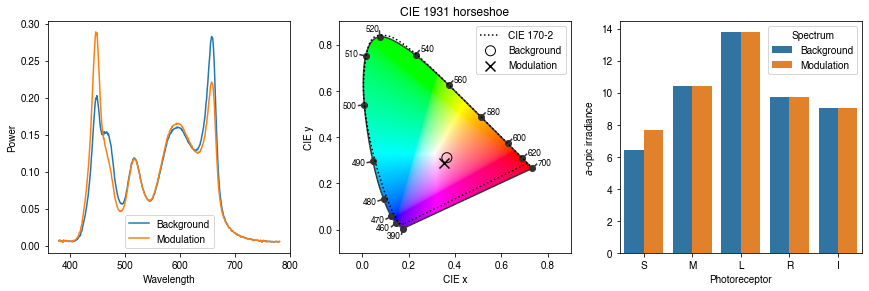

In [8]:
result_fig = ssp.plot_solution(amod)

Contrast modulations
--------------------

Multiprimary devices with good linearity, high resolution and rapid spectral switching capability may be used to present temporal modulations of photoreceptor-targeted contrast. Such stimuli have helped to shed light on how the pupil responds to input from different photoreceptors as a function of time (e.g., [Barrionuevo et al., 2016](https://jov.arvojournals.org/article.aspx?articleid=2565122); [Spitschan et al., 2014](https://www.pnas.org/doi/10.1073/pnas.1400942111)). 

To make contrast modulations, first define a stimulus profile with a sampling frequency in line with the switching capability of the stimulation device. In this case, its a 1 Hz sinusoid with 50 samples per cycle.


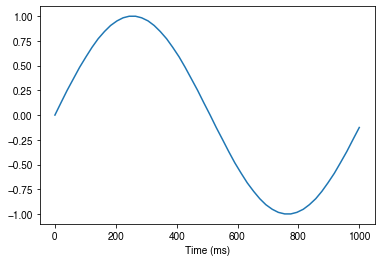

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sinusoid_modulation(f, duration, Fs=50):
    """Generate a sinusoidal waveform"""
    x = np.arange(duration * Fs)
    return np.sin(2 * np.pi * f * x / Fs)

stimulus_profile = sinusoid_modulation(1, 1)
time = np.linspace(0, 1000, 50).astype('int')

plt.plot(time, stimulus_profile)
plt.xlabel('Time (ms)');

Now, define a problem. Here we define the background spectrum as all primaries at half-max power so we can maximise bidirectional contrast. Then we say that we want to ignore rods, minimize contrast on M-cones, L-cones and melanopsin, and modulate the S-cones.

In [2]:
# Load some example data for a 10-primary system
ssp = SSP.from_json('../../data/STLAB_1_York.json')

ssp.background = [.5] * ssp.nprimaries
ssp.ignore = ['R']
ssp.minimize = ['M', 'L', 'I']
ssp.modulate = ['S']
ssp.print_problem()

NameError: name 'SSP' is not defined

Next, choose a peak contrast value that is known to be in gamut and solve for each point in the stimulus profile. The algebraic approach is well suited here as it guarantees a linear uni-directional scaling of the primaries and is less computationally expensive than optimisation. 

In [11]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

Plotting the forward projection of contrast for each solution in this case reveals a smooth S-cone modulation with little contrast splatter on the other photoreceptors.

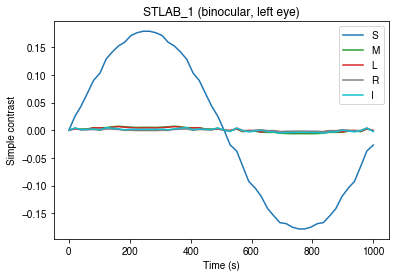

In [12]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.aopic_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

Finally, convert the solutions to settings compatible with the native resolution of the stimulation device.

In [13]:
device_settings = [ssp.w2s(s) for s in solutions]
device_settings = pd.DataFrame(device_settings, index=time)
with pd.option_context('display.max_rows', 10):
    print(device_settings)

         0     1     2     3     4     5     6     7     8     9
0     2047  2047  2047  2047  2047  2047  2047  2047  2047  2047
20    2162  2181  2047  2006  1950  2038  2101  2027  2004  2012
40    2276  2314  2047  1967  1855  2030  2154  2007  1961  1978
61    2386  2442  2047  1928  1762  2021  2206  1987  1920  1945
81    2491  2564  2047  1891  1674  2013  2255  1969  1880  1914
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
918   1505  1417  2046  2237  2502  2088  1793  2142  2250  2209
938   1603  1530  2047  2203  2420  2081  1839  2125  2214  2180
959   1708  1652  2047  2166  2332  2073  1888  2107  2174  2149
979   1818  1780  2047  2127  2239  2064  1940  2087  2133  2116
1000  1932  1913  2047  2088  2144  2056  1993  2067  2090  2082

[50 rows x 10 columns]


Now you just need to tell the stimulation device to set the primary inputs to these values at the specified timepoints and it will produce the S-cone modulation shown above. 

Note that with this method one can also modulate multiple photoreceptors together.

In [14]:
ssp.ignore = ['R']
ssp.minimize = ['I']
ssp.modulate = ['S', 'M', 'L']

In [15]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

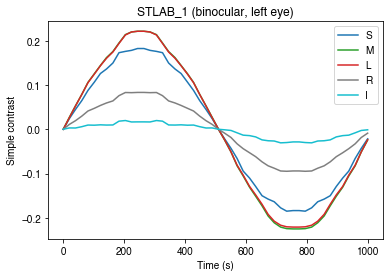

In [16]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.aopic_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();

We can even modulate photoreceptors in counterphase.

In [17]:
peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    c = point * peak_contrast
    ssp.target_contrast = [-c, c, c]
    solutions.append(ssp.linalg_solve())

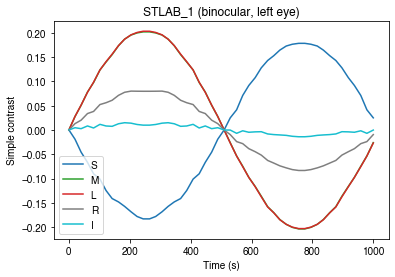

In [18]:
fig, ax = plt.subplots(1, 1)

splatter = [ssp.get_photoreceptor_contrasts(s) for s in solutions]
splatter = pd.concat(splatter, axis=1)    

for r, s in splatter.iterrows():
    ax.plot(time, s, label=r, color=ssp.aopic_colors[r])
        
    ax.set_ylabel('Simple contrast')
    ax.set_title(ssp.name)
    ax.set_xlabel('Time (s)')
    
plt.legend();